In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib

from skglm import GeneralizedLinearEstimator
from skglm.penalties import WeightedL1
from skglm.datafits import Quadratic
from utils import comp_sharpe_ratio, comp_sortion_ratio, comp_MDD, comp_calmar_ratio

matplotlib.rcParams.update({'font.size': 16})

In [3]:
company_table = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]
stock_list = company_table['Ticker'].to_list()

In [4]:
start_time = '2017-01-01'
end_time = '2022-12-31'

stock_data = []
for idx in stock_list:
    temp_data = yf.download(idx, start=start_time, end=end_time)
    data_ = pd.DataFrame()
    data_[idx] = temp_data['Adj Close']
    stock_data.append(data_)

stock_data = pd.concat(stock_data, axis=1)
stock_data = stock_data.reset_index()
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format="%d-%m-%Y").dt.date
stock_data = stock_data.set_index('Date')

stock_data = stock_data.fillna(method='ffill')
stock_data = stock_data.fillna(method='bfill')

stock_pct = stock_data.pct_change()[1:]
stock_idx = stock_pct.index 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
nasdaq_data =  yf.download('^NDX', start=start_time, end=end_time)['Adj Close']

nasdaq_data = nasdaq_data.fillna(method='ffill')
nasdaq_data = nasdaq_data.fillna(method='bfill')

nasdaq_pct = nasdaq_data.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


In [18]:
train_widnow = 100
test_window = 30

X = stock_pct.values * 100
y = nasdaq_pct.values * 100

T = X.shape[0]
y_est_dict = {}

y_gt_list = []
y_est_list = []

S = (1/T) * X.T.dot(X)
eigen_vals, eigen_vects = np.linalg.eig(S)
eigen_vals = eigen_vals / np.sum(eigen_vals)

alphas = [i for i in np.arange(0, 2.2, 0.2)]

for idx, alpha in enumerate(alphas):
    alpha = round(alpha, 3)
    model = GeneralizedLinearEstimator(Quadratic(), WeightedL1(alpha=alpha, weights=eigen_vals, positive=True))
    
    for i in range(train_widnow, T - test_window, test_window):
        X_train = X[i - train_widnow:i, :]
        y_train = y[i - train_widnow:i]

        X_test = X[i:i + test_window, :]
        y_test = y[i:i + test_window]

        model.fit(X_train, y_train)
        w_est = model.coef_
        w_est = w_est / np.sum(w_est)
        y_est = X_test.dot(w_est)

        y_est_list.append(y_est)
        y_gt_list.append(y_test)
        
    y_res = np.concatenate(y_est_list)
    y_gt = np.concatenate(y_gt_list)
    
    y_est_dict[alpha] = y_res
    
    y_est_list = [] 
    y_gt_list = []

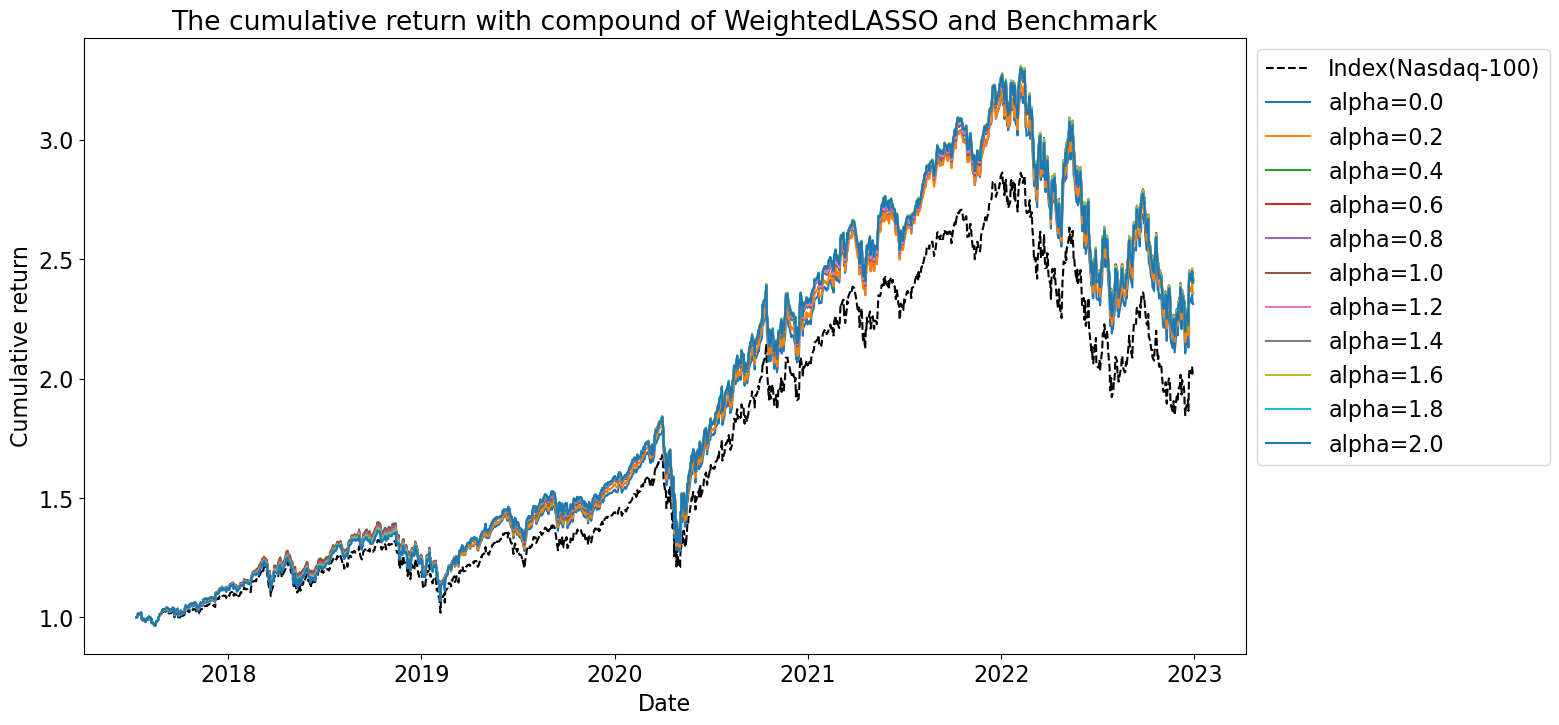

In [19]:
plt.figure(figsize=(15, 8))
indx = stock_idx[train_widnow + test_window-1:]
plt.plot(indx, np.cumprod((1 + y_gt/100)), '--', color='black', label = 'Index(Nasdaq-100)')

for key, val in y_est_dict.items():
    plt.plot(indx, np.cumprod((1+val/100)), label='alpha=' + str(key))

plt.ylabel("Cumulative return")
plt.xlabel("Date")
plt.title("The cumulative return with compound of WeightedLASSO and Benchmark")
plt.legend(bbox_to_anchor=(1.00, 1.0), loc='upper left')
plt.show()

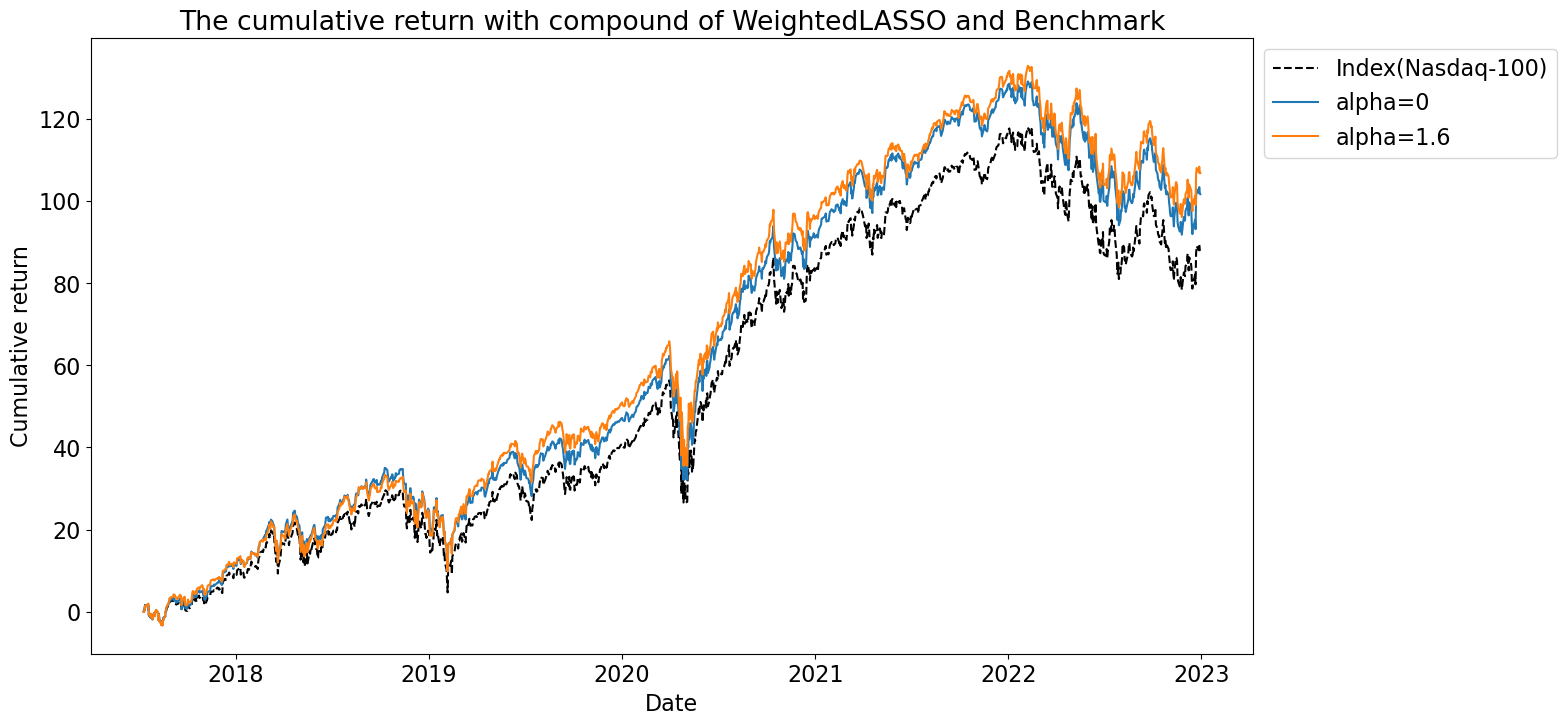

In [23]:
plt.figure(figsize=(15, 8))
plt.plot(indx, np.cumsum(y_gt), '--', color='black', label = 'Index(Nasdaq-100)')
plt.plot(indx, np.cumsum(y_est_dict[0]), label='alpha=' + str(0))
plt.plot(indx, np.cumsum(y_est_dict[1.6]), label='alpha=' + str(1.6))
plt.ylabel("Cumulative return")
plt.xlabel("Date")
plt.title("The cumulative return with compound of WeightedLASSO and Benchmark")
plt.legend(bbox_to_anchor=(1.00, 1.0), loc='upper left')
plt.show()

In [16]:
def comp_measures(X, N=256, rf=0.00):
    
    sharpe_ratio = comp_sharpe_ratio(X, N, rf)
    sortion_ratio = comp_sortion_ratio(X, N, rf)
    maxDD, maxDDD, i = comp_MDD(X)
    calmer_ratio = comp_calmar_ratio(X)

    print("sharpe ratio is {:.4f}, sortion ratio is {:.4f}, the calmer ratio is {:.4f}".format(sharpe_ratio, 
                                                                                               sortion_ratio, 
                                                                                               calmer_ratio)) 
    print("the maximum drawdown is {:.4f}, the duration of maximum drawdown is {:.4f}\n".format(maxDD, maxDDD))

In [21]:
for key, val in y_est_dict.items():
    print("the parameter:", key)
    comp_measures(val/100)

the parameter: 0.0
sharpe ratio is 0.7351, sortion ratio is 0.9238, the calmer ratio is 0.7206
the maximum drawdown is -0.2606, the duration of maximum drawdown is 226.0000

the parameter: 0.2
sharpe ratio is 0.7479, sortion ratio is 0.9421, the calmer ratio is 0.7512
the maximum drawdown is -0.2552, the duration of maximum drawdown is 226.0000

the parameter: 0.4
sharpe ratio is 0.7599, sortion ratio is 0.9565, the calmer ratio is 0.7607
the maximum drawdown is -0.2565, the duration of maximum drawdown is 226.0000

the parameter: 0.6
sharpe ratio is 0.7641, sortion ratio is 0.9623, the calmer ratio is 0.7652
the maximum drawdown is -0.2568, the duration of maximum drawdown is 226.0000

the parameter: 0.8
sharpe ratio is 0.7611, sortion ratio is 0.9588, the calmer ratio is 0.7617
the maximum drawdown is -0.2575, the duration of maximum drawdown is 226.0000

the parameter: 1.0
sharpe ratio is 0.7606, sortion ratio is 0.9593, the calmer ratio is 0.7620
the maximum drawdown is -0.2576, th